In [11]:
import random
from prettytable import PrettyTable

'''
Defining the state space(S), action space(A), and transition function

T: Number of stages of finite horizon
X0 = Initial stock in warehouse
a = per unit storage cost
b = per unit backlog cost
p = per unit price of stock
U = number of procured stocks 0..U
S = state space is [-S,S]
W = random demand 0..W
num_iterations = number of iterations in Algorithm
'''

T = 10
a = 2 
b = 3 
p = 1 
U = 10 
S = 20
W = 10 
num_itetations = 1000

In [12]:
'''
T = 20
a = 5
b = 10
p = 2
U = 15
S = 40
W = 10
num_itetations = 1000
'''

'\nT = 20\na = 5\nb = 10\np = 2\nU = 15\nS = 40\nW = 10\nnum_itetations = 1000\n'

In [13]:
'''
Initialization step: Q[(n,i,a)] 
time step: n
state: i
action: a
'''

Q = {}
for n in range(T+1):
    for i in range(-S, S+1):
        for a in range(0, U+1):
            Q[(n,i,a)] = 0 # Initialization and terminal state updation

In [14]:
'''
Defining system dynamics
'''

def next_state(Xt, Ut):
    '''
    Finds the next state of MDP
    Xt: i(current state)
    Ut: a(action)
    '''
    Wt = random.randint(0, W)
    X = Xt + Ut - Wt
    X = min(S, max(X, -S))
    return X

def cost_function(i, a, j):
    '''
    i (current state), a (action), j (next state)
    '''
    cost = p * a
    h = a * j if j > 0 else -b*j
    cost += h
    return cost

In [15]:
rewards_per_episode = []
start_states = []

# Episode generation following the greedy policy from Queue values learned till now
def generate_episode(start_state):
    curr = start_state
    reward = 0
    for t in range(T):
        vals = [ Q[(t, curr, a)] for a in range(0, U+1) ]
        a = vals.index(min(vals))
        next = next_state(curr, a)  # action corresponding to min Q value, greedy action
        reward += cost_function(curr, a, next)
    
    return reward

In [16]:
def update_queue_values(n, i, a, m):
    '''
    n (stage), i (current state), a (action), m (recursion)
    '''
    am = 10 / (m+1)
    j = next_state(i, a)
    r = cost_function(i, a, j)
    minQ = min([ Q[(n+1, j, b)] for b in range(0, U+1)])
    Q[(n,i,a)] = (1-am) * Q[(n,i,a)] + am * (r + minQ)

'''
Train the Q values by simulations

complexity: num_iterations * N * S * U ~ 1e7
'''

for m in range(num_itetations):
    # Apllying stochastic approximation results, iterating over all s,a pairs and applyin update eqn.
    for n in range(T):
        for i in range(-S, S+1):
            for a in range(0, U+1):
                update_queue_values(n, i, a, m)

    # Randomly Generating the start state
    state = random.randint(-S, S)    
    start_states.append(state)  
    rewards_per_episode.append(generate_episode(state)) # Genrating the episod with the current learned Q values


In [17]:
regrets=[]

for m in range(num_itetations):
    vals = [ Q[(0, start_states[m], a)] for a in range(0, U+1) ]
    Va = min(vals)
    regrets.append(rewards_per_episode[m] - Va)

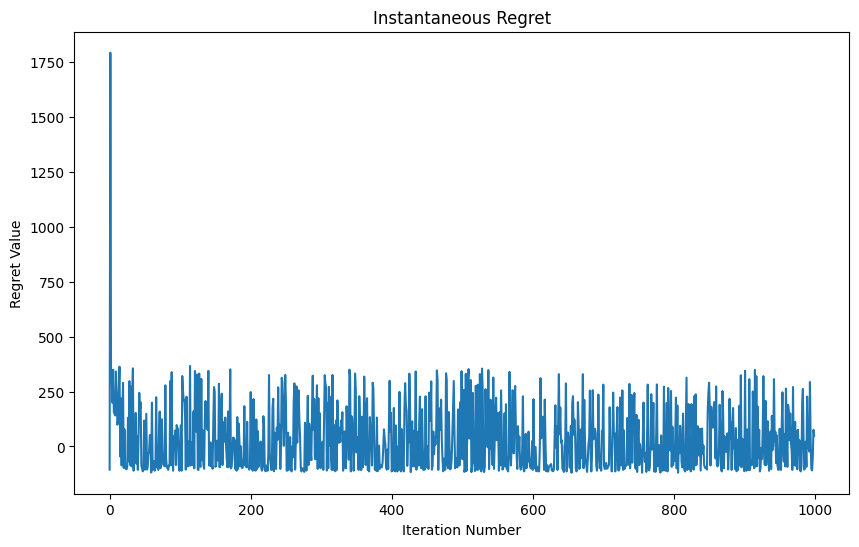

In [18]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(regrets)
plt.title("Instantaneous Regret")
plt.xlabel("Iteration Number")
plt.ylabel("Regret Value")
plt.show()

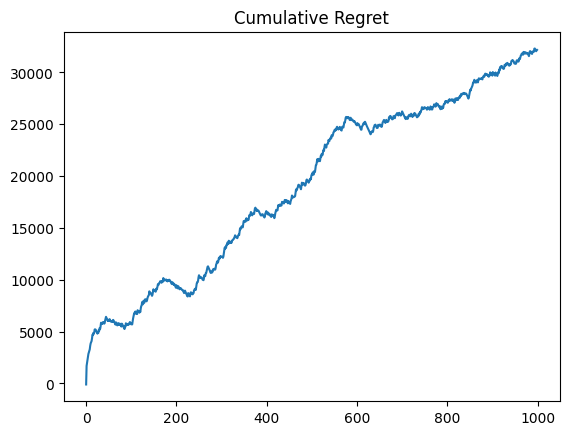

In [19]:
import numpy as np

arr_tot = np.cumsum(regrets)
plt.plot(arr_tot)
plt.title("Cumulative Regret")
plt.show()

In [20]:
'''
Find optimal action at stage n, state i
'''

optimal_action = [[0 for _ in range(2*S+1)] for _ in range(T)] # stages * states

for n in range(T):
    for i in range(-S, S+1):
        vals = [ Q[(n, i, a)] for a in range(0, U+1) ]
        op_a = vals.index(min(vals))
        optimal_action[n][i+S] = op_a

# Create a PrettyTable
table = PrettyTable()

# Add column headers
col_labels = list( range(-S, S+1) )
table.field_names = [""] + col_labels

# Add rows with values
row_labels = list( range(T) )
for i in range(len(row_labels)):
    table.add_row([row_labels[i]] + optimal_action[i])

# Print the table
print(table)

+---+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+----+----+----+----+----+----+----+----+---+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+
|   | -20 | -19 | -18 | -17 | -16 | -15 | -14 | -13 | -12 | -11 | -10 | -9 | -8 | -7 | -6 | -5 | -4 | -3 | -2 | -1 | 0 | 1 | 2 | 3 | 4 | 5 | 6 | 7 | 8 | 9 | 10 | 11 | 12 | 13 | 14 | 15 | 16 | 17 | 18 | 19 | 20 |
+---+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+-----+----+----+----+----+----+----+----+----+----+---+---+---+---+---+---+---+---+---+---+----+----+----+----+----+----+----+----+----+----+----+
| 0 |  10 |  10 |  10 |  10 |  10 |  10 |  10 |  10 |  10 |  10 |  10 | 10 | 9  | 9  | 9  | 7  | 7  | 6  | 7  | 5  | 4 | 4 | 3 | 2 | 2 | 1 | 1 | 0 | 0 | 0 | 0  | 0  | 0  | 0  | 0  | 0  | 0  | 0  | 0  | 0  | 0  |
| 1 |  10 |  10 |  10 |  10 |  10 |  10 |  10 |  10 |  10 |  10 |  10 | 10 | 9  | 10 | 8  | 7  | 7  | 6  | 4  | 5  | 4 | 3 | 3 | 2 | 1 | 2 | 1 | 0 | 0 |